In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import zeros, ones, eye
from torch.distributions import MultivariateNormal
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.analysis import pairplot
from sbi.utils.metrics import c2st

from sbi.simulators.linear_gaussian import linear_gaussian, true_posterior_linear_gaussian_mvn_prior

In [2]:
# Gaussian simulator
theta_dim = 2
x_dim = theta_dim
# likelihood_mean will be likelihood_shift+theta
likelihood_shift = -1.0 * zeros(x_dim)
likelihood_cov = 0.3 * eye(x_dim)

prior_mean = zeros(theta_dim)
prior_cov = eye(theta_dim)
prior = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov)

simulator, prior = prepare_for_sbi(lambda theta: linear_gaussian(theta, likelihood_shift, likelihood_cov), prior)

def get_true_posterior_samples(x_o, num_samples=1):
    return true_posterior_linear_gaussian_mvn_prior(x_o, 
                                                    likelihood_shift, 
                                                    likelihood_cov, 
                                                    prior_mean, 
                                                    prior_cov).sample((num_samples,))

## The analytical posterior concentrates around true parameters with increasing number of IID trials 

In [3]:
num_trials = [1, 5, 15, 20]
tho = zeros(1, theta_dim)

xos = [tho.repeat(nt, 1) for nt in num_trials]
ss = [get_true_posterior_samples(xo, 5000) for xo in xos]

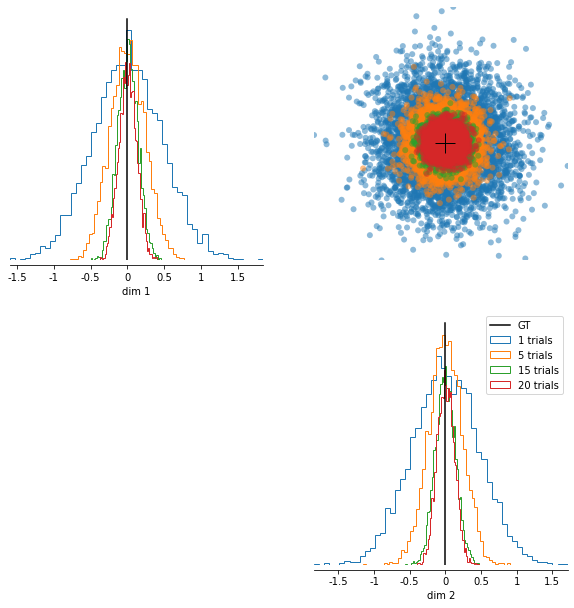

In [4]:
fig, ax = pairplot(ss, points=tho, upper="scatter", points_colors=["k"], 
         points_offdiag=dict(marker="+"))
plt.sca(ax[1, 1])
plt.legend(["GT"] + [f"{nt} trials" for nt in num_trials]);

## IID x inference with NLE

(S)NLE can easily perform inference given multiple IID x because it based on learning the likelihood. Once the likelihood is learned, i.e., a neural network that given a single observation and a parameter predicts the likelihood of that observation given the parameter, one can perform MCMC to obtain posterior samples. 

MCMC relies on evaluating ratios of likelihoods of candidate parameters to either accept or reject them to be posterior samples. When inferring the posterior given multiple IID observation, these likelihoods are just the joint likelihoods of each IID observation given the current parameter candidate. Thus, given a neural likelihood from SNLE, we can calculate these joint likelihoods and perform MCMC given IID data:

In [12]:
# Train SNLE.
inferer = SNLE(prior, show_progress_bars=True, density_estimator="mdn")
theta, x = simulate_for_sbi(simulator, prior, 100000, simulation_batch_size=1000)
inferer.append_simulations(theta, x).train(training_batch_size=100);

Running 100000 simulations.:   0%|          | 0/100000 [00:00<?, ?it/s]

Neural network successfully converged after 34 epochs.


In [13]:
# Obtain posterior samples for different number of iid xos. 
samples = []
num_samples = 5000

mcmc_parameters = dict(
    num_chains = 20,
    thin = 10,
    warmup_steps= 100,
    init_strategy= "sir",
    sir_batch_size = 1000,
    sir_num_batches = 100,
)
mcmc_method = "slice_np_vectorized"

for xo in xos:
    posterior = inferer.build_posterior(
        mcmc_method=mcmc_method, 
        mcmc_parameters=mcmc_parameters,
    ).set_default_x(xo)
    samples.append(posterior.sample(sample_shape=(num_samples,)))

  0%|          | 0/70000 [00:00<?, ?it/s]

Generating MCMC samples


  0%|          | 0/70000 [00:00<?, ?it/s]

Generating MCMC samples



 20%|█▉        | 13990/70000 [00:16<01:16, 727.65it/s]


 41%|████▏     | 28880/70000 [00:33<00:45, 913.54it/s]


 62%|██████▏   | 43580/70000 [00:50<00:40, 651.16it/s]


 85%|████████▌ | 59500/70000 [01:09<00:09, 1113.19it/s]


  0%|          | 0/70000 [00:00<?, ?it/s]

Generating MCMC samples


  0%|          | 0/70000 [00:00<?, ?it/s]

Generating MCMC samples


100%|██████████| 70000/70000 [02:01<00:00, 148.53it/s]

100%|██████████| 70000/70000 [02:01<00:00, 574.98it/s]


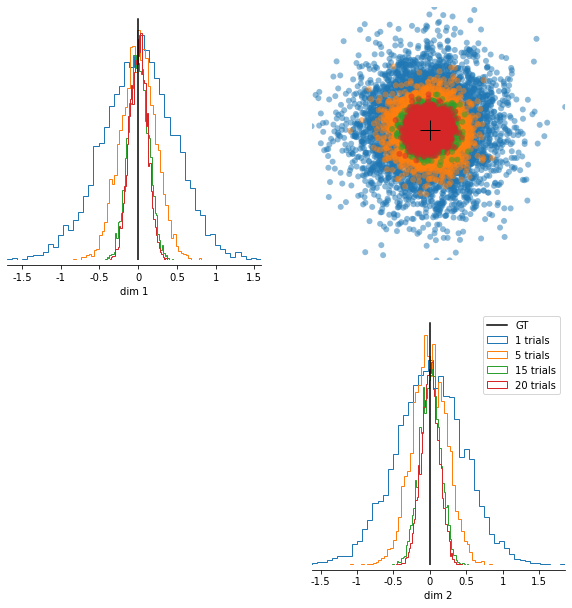

In [14]:
fig, ax = pairplot(samples, points=tho, upper="scatter", points_colors=["k"], 
         points_offdiag=dict(marker="+"))
plt.sca(ax[1, 1])
plt.legend(["GT"] + [f"{nt} trials" for nt in num_trials]);

In [15]:
cs = [c2st(torch.from_numpy(s1), torch.from_numpy(s2)) for s1, s2 in zip(ss, samples)]

In [16]:
cs

[tensor([0.4997]), tensor([0.5170]), tensor([0.5140]), tensor([0.5204])]